# Sports Activity Analysis on the Human Action Dataset (HAD)

This model implementation tries to classify sports activity from fMRI data, brain signals, available at Human Action Dataset https://doi.org/10.18112/openneuro.ds004488.v1.1.1

## Prerequisite Installation
For installation of packages follow below instructions:
(Note: brainiak does not have windows support, works in linux https://pypi.org/project/brainiak/)
- conda create -n fmri_env
- conda activate fmri_env
- conda install -c brainiak -c defaults -c conda-forge brainiak
- python3 -m pip install -U tensorflow tensorflow-probability
- conda install jupyter nilearn ipykernel chardet
- python -m ipykernel install --user --name fmri_env --display-name fmri_env

(For detailed packages list refer attached fmri_env.yml file in sourcecode zip)

## Section 1: Data Preparation

In this section of notebook, we will:
1. Load and preprocess fMRI data from the Human Action Dataset (HAD).
2. Extract and process activity-specific data related to "Playing sports".
3. Save processed beta maps for use in further analysis.


### 1. Setting Up Paths and Imports

In [2]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import logging
from os.path import join as pjoin
from nilearn.image import resample_to_img
from nilearn.glm.first_level import make_first_level_design_matrix
from sklearn.linear_model import Ridge
from nibabel import cifti2

# Setup logging to monitor the process
logging.basicConfig(filename='fMRI_Beta_processing.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Define the necessary paths for dataset, preprocessing, and support files
dataset_path = r"/mnt/d/MS/research/datasets/fMRI_human_action_recognition"
ciftify_path = f'{dataset_path}/derivatives/ciftify'
nifti_path = dataset_path
support_path = r'/mnt/d/MS/research/datasets/analysis/fmri_sports_activity_recognition/support_files'
excel_path = pjoin(support_path, 'Supplementary Table 1.xlsx')
save_path = r"/mnt/d/MS/research/datasets/fMRI_human_action_recognition/extracted/sports_beta"


### 2. Define Utility Functions

Below is a utility function `contains_any` that checks if an entry contains any filter values, used to filter activities later.

In [3]:
def contains_any(entry, filter_values):
    return any(fv in entry for fv in filter_values)

### 3. Loading Activity Information from Excel

We load activity information from an Excel file to identify the "Playing sports" category.


In [4]:
# Load the list of activities from the Excel file
activity = pd.read_excel(excel_path, sheet_name=0)

# Identify "Playing sports" related activities
sports_activity_df = activity[activity["parentName"] == 'Playing sports']
sports_activities = sports_activity_df["nodeName"].tolist()
sports_activities.sort()

# Check the identified activities
print(f"Identified 'Playing sports' activities: {sports_activities}")

Identified 'Playing sports' activities: ['Archery', 'Baton twirling', 'Bungee jumping', 'Camel ride', 'Cricket', 'Croquet', 'Curling', 'Discus throw', 'Dodgeball', 'Doing a powerbomb', 'Doing motocross', 'Hammer throw', 'High jump', 'Hurling', 'Javelin throw', 'Long jump', 'Longboarding', 'Paintball', 'Playing kickball', 'Pole vault', 'Powerbocking', 'Rollerblading', 'Shot put', 'Skateboarding', 'Starting a campfire', 'Triple jump']


### 4. Setting Parameters for fMRI Data Processing

Define the parameters related to the dataset, such as TR (Repetition Time), the number of cycles, runs, events, and others.


In [5]:
# Prepare necessary parameters
sub_names = ['sub-%02d' % (i + 1) for i in range(30)]  # 30 subjects
n_class = len(sports_activities)
sess_name = 'ses-action01'
tr, begin_dur, n_tr, n_event, n_run, n_cycle = 2, 12, 156, 60, 12, 4  # fMRI parameters
alpha = 0.1  # Regularization parameter for Ridge regression
frame_times = np.arange(n_tr * 3) * tr  # Time points across TRs


### 5. Process Individual Subjects and Extract Beta Maps

The following block processes each subject in the dataset, applies GLM (General Linear Model), and extracts beta maps for activities related to "Playing sports". Each subject's data is processed in cycles.


In [6]:
# Function to process a single subject
def process_subject(sub_name):
    try:
        # prepare basic path
        sub_nifti_path = pjoin(nifti_path, sub_name)
        result_path = pjoin(ciftify_path, sub_name, 'results')
        sub_func_path = pjoin(sub_nifti_path, sess_name, 'func')
        events_file = sorted([i for i in os.listdir(sub_func_path) if i.endswith('.csv')])
        output_path = pjoin(save_path, sub_name)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        # loop in cycles to perform linear regression model
        for cycle_idx in range(n_cycle):
            beta = np.zeros((n_class, 59412), dtype=np.float32)
            # intial containers
            trial_type_cycle = []
            stim_names_cycle = []
            sports_label = []
            dtseries_cycle = np.zeros((3*n_tr, 91282))
            onset_cycle = np.zeros((3*n_event))
            duration_cycle = np.zeros((3*n_event))
            for run_idx in range(3):
                run_file_idx = run_idx + cycle_idx * 3 + 1
                events_file_name = '%s_ses-action01_task-action_run-%02d_events.tsv'%(sub_name, run_file_idx)
                run_name = 'ses-action01_task-action_run-%d'% run_file_idx
                # Reading Events for the run id
                try:
                    events_raw = pd.read_csv(pjoin(sub_func_path, events_file_name), sep='\t')
                except FileNotFoundError:
                    logging.warning(f'Events file not found: {events_file_name} for run {run_file_idx}')
                    continue

                # Filter events based on sports activities
                sports_events = events_raw[events_raw['stim_file'].apply(lambda x: contains_any(x, sports_activities))]
                sports_tmp = sports_events['trial_type'].to_numpy()
                
                duration = events_raw['duration']
                onset = events_raw['onset'].to_numpy() + begin_dur
                label_tmp = events_raw['trial_type'].to_numpy()
                trial_type = ['category-%03d'%idx for idx in label_tmp]
                stim_names = [_.split('/')[0] for _ in events_raw['stim_file']]
                # load time series
                dtseries_path = pjoin(result_path, f'{run_name}_Atlas.dtseries.nii')
                dtseries = nib.load(dtseries_path).get_fdata()
                # concantenate all info into cycle params
                dtseries_cycle[n_tr*run_idx:n_tr*(run_idx+1)] = dtseries
                onset_cycle[n_event*run_idx:n_event*(run_idx+1)] = onset + run_idx * n_tr * tr
                duration_cycle[n_event*run_idx:n_event*(run_idx+1)] = duration
                trial_type_cycle.extend(trial_type)
                stim_names_cycle.extend(stim_names)
                sports_label.extend(sports_tmp)
                
            # Getting Category Ids for the sportsal activities
            sports_labels = list(np.unique(sports_label))
            sports_classes = ['category-%03d' % idx for idx in sports_labels]
            # Filter trial_type_cycle and corresponding data to include only sports classes
            filtered_indices = [i for i, tt in enumerate(trial_type_cycle) if tt in sports_classes]
            trial_type_cycle = [trial_type_cycle[i] for i in filtered_indices]
            stim_names_cycle = [stim_names_cycle[i] for i in filtered_indices]
            onset_cycle = onset_cycle[filtered_indices]
            duration_cycle = duration_cycle[filtered_indices]
            
            # prepare design matrix
            events = pd.DataFrame({'trial_type':trial_type_cycle, 'onset':onset_cycle, 'duration':duration_cycle})
            design_matrix = make_first_level_design_matrix(frame_times, events, drift_model=None, hrf_model='spm')
            design_matrix.drop(design_matrix.columns[-1], axis=1, inplace=True)
            # add drift columns
            drift_order = 2
            frame_times_single = np.arange(n_tr) * tr 
            drift_effect = np.zeros((n_tr * 3, 3*(drift_order+1)))
            tmax = float(frame_times_single.max())
            for run_idx in range(3):
                for k in range(drift_order+1):
                    drift_effect[n_tr*run_idx:n_tr*(run_idx+1), (drift_order+1)*run_idx+k] = (frame_times_single / tmax) ** k
            drift_effect = pd.DataFrame(drift_effect)
            # concantenate 
            design_matrix = pd.concat([design_matrix.reset_index(drop=True), drift_effect], ignore_index=True, axis=1)  
            # perform GLM
            reg = Ridge(alpha=alpha, fit_intercept=False).fit(design_matrix.values, dtseries_cycle[:, :59412])
            beta = reg.coef_[:, :n_class].transpose(1,0).astype(np.float32)
            print('Finish performing GLM in %s %s model %02d in alpha %.3f'%(sub_name, sess_name, cycle_idx+1, alpha))
            logging.info('Finish performing GLM in %s %s model %02d in alpha %.3f'%(sub_name, sess_name, cycle_idx+1, alpha))
            
            # Convert 'category-046' to '46'
            label_cycle = [int(label.split('-')[1]) for label in trial_type_cycle]

            # Sorting labels and corresponding data based on the order in sports_activities
            sorted_indices = [sports_activities.index(name) for name in stim_names_cycle]
            sorted_indices = np.argsort(sorted_indices)

            label_sorted = np.array([label_cycle[idx] for idx in sorted_indices])
            beta_sorted = beta[sorted_indices, :]
            
            # save beta and label information
            label_path = pjoin(output_path, f'{sub_name}_task-action_cycle-{cycle_idx+1}_label.npy')
            np.save(label_path, label_sorted)
            
            '''
            # write trial_type_cycle info  into txt 
            with open(label_path, 'w') as f:
                f.writelines([line+'\n' for line in label_sorted]) 
            '''
                
            # save beta
            beta_path = pjoin(output_path, f'{sub_name}_cycle-{cycle_idx+1}_beta.dscalar.nii')
            temp = nib.load(pjoin(support_path, 'template.dtseries.nii'))
            bm = list(temp.header.get_index_map(1).brain_models)[0:2]
            save2cifti(file_path=beta_path, data=beta_sorted, brain_models=bm, map_names=stim_names_cycle)
    
    except Exception as e:
        logging.error(f"Error processing subject {sub_name}: {str(e)}")


In [7]:
# This function, save2cifti, is from MRI preprocessing code of HAD paper DOI: https://doi.org/10.1038/s41597-023-02325-6 

def save2cifti(file_path, data, brain_models, map_names=None, volume=None, label_tables=None):
    if file_path.endswith('.dlabel.nii'):
        assert label_tables is not None
        idx_type0 = 'CIFTI_INDEX_TYPE_LABELS'
    elif file_path.endswith('.dscalar.nii'):
        idx_type0 = 'CIFTI_INDEX_TYPE_SCALARS'
    elif file_path.endswith('.dtseries.nii'):
        if len(data.shape) > 1:
            brain_models.header.get_index_map(0).number_of_series_points = data.shape[0]
        else:
            brain_models.header.get_index_map(0).number_of_series_points = 1
            data = data[np.newaxis, :]
        nib.save(nib.Cifti2Image(data.astype(np.float32), brain_models.header), file_path)
        return # jump out of function
    else:
        raise TypeError('Unsupported File Format')

    if map_names is None:
        map_names = [None] * data.shape[0]
    else:
        assert data.shape[0] == len(map_names), "Map_names are mismatched with the data"

    if label_tables is None:
        label_tables = [None] * data.shape[0]
    else:
        assert data.shape[0] == len(label_tables), "Label_tables are mismatched with the data"

    # CIFTI_INDEX_TYPE_SCALARS always corresponds to Cifti2Image.header.get_index_map(0),
    # and this index_map always contains some scalar information, such as named_maps.
    # We can get label_table and map_name and metadata from named_map.
    mat_idx_map0 = cifti2.Cifti2MatrixIndicesMap([0], idx_type0)
    for mn, lbt in zip(map_names, label_tables):
        named_map = cifti2.Cifti2NamedMap(mn, label_table=lbt)
        mat_idx_map0.append(named_map)

    # CIFTI_INDEX_TYPE_BRAIN_MODELS always corresponds to Cifti2Image.header.get_index_map(1),
    # and this index_map always contains some brain_structure information, such as brain_models and volume.
    mat_idx_map1 = cifti2.Cifti2MatrixIndicesMap([1], 'CIFTI_INDEX_TYPE_BRAIN_MODELS')
    for bm in brain_models:
        mat_idx_map1.append(bm)
    if volume is not None:
        mat_idx_map1.append(volume)

    matrix = cifti2.Cifti2Matrix()
    matrix.append(mat_idx_map0)
    matrix.append(mat_idx_map1)
    header = cifti2.Cifti2Header(matrix)
    img = cifti2.Cifti2Image(data, header)
    cifti2.save(img, file_path)

### 6. Processing All Subjects

We loop through all subjects and apply the `process_subject` function for each one.

In [8]:
# Process each subject in the dataset
for sub_name in sub_names:
    process_subject(sub_name)

Finish performing GLM in sub-01 ses-action01 model 01 in alpha 0.100
Finish performing GLM in sub-01 ses-action01 model 02 in alpha 0.100
Finish performing GLM in sub-01 ses-action01 model 03 in alpha 0.100
Finish performing GLM in sub-01 ses-action01 model 04 in alpha 0.100
Finish performing GLM in sub-02 ses-action01 model 01 in alpha 0.100
Finish performing GLM in sub-02 ses-action01 model 02 in alpha 0.100
Finish performing GLM in sub-02 ses-action01 model 03 in alpha 0.100
Finish performing GLM in sub-02 ses-action01 model 04 in alpha 0.100
Finish performing GLM in sub-03 ses-action01 model 01 in alpha 0.100
Finish performing GLM in sub-03 ses-action01 model 02 in alpha 0.100
Finish performing GLM in sub-03 ses-action01 model 03 in alpha 0.100
Finish performing GLM in sub-03 ses-action01 model 04 in alpha 0.100
Finish performing GLM in sub-04 ses-action01 model 01 in alpha 0.100
Finish performing GLM in sub-04 ses-action01 model 02 in alpha 0.100
Finish performing GLM in sub-04 se

Finish performing GLM in sub-30 ses-action01 model 04 in alpha 0.100


In this section we have extracted and prepared fMRI data of the **Human Action Dataset (HAD)** for **"Playing sports"** activities. The extracted data we will be using for further analysis and modeling.

## Section 2: Model Building and Evaluation

In [10]:
# Path and subject setting
beta_path = r'/mnt/d/MS/research/datasets/fMRI_human_action_recognition/extracted/sports_beta'
sub_names = ['sub-%02d'%(i+1) for i in range(30)]

In [11]:
import numpy as np
import nibabel as nib
from os.path import join as pjoin

# Assuming beta_map_paths is a list of paths to beta maps for each subject and cycle
beta_maps = []
labels = []

for sub_idx, sub_name in enumerate(sub_names):
    subject_beta_maps = []
    subject_labels = []
    for cycle_idx in range(4):
        # Load beta map
        beta_map_path = pjoin(beta_path, sub_name, f'{sub_name}_cycle-{cycle_idx+1}_beta.dscalar.nii')
        beta_map = nib.load(beta_map_path).get_fdata()
        subject_beta_maps.append(beta_map)

        # Load labels
        label_path = pjoin(beta_path, sub_name, f'{sub_name}_task-action_cycle-{cycle_idx+1}_label.npy')
        label = np.load(label_path)
        subject_labels.append(label)

    beta_maps.append(subject_beta_maps)
    labels.append(subject_labels)

beta_maps = np.array(beta_maps)  # Shape: (30, 4, X, Y, Z) where X, Y, Z are dimensions of the beta maps
labels = np.array(labels)        # Shape: (30, 4, 24)

In [12]:
print(beta_maps.shape)
print(labels.shape)

(30, 4, 24, 59412)
(30, 4, 24)


In [13]:
def get_label_mapping_as_order(labels):
    dist_labels = np.unique(labels)
    dist_labels.sort()
    label_map = {}
    for i, j in enumerate(dist_labels):
        label_map[j] = i+1
    return label_map

In [14]:
import numpy as np

# sports labels=> 1,   8,  19,  21,  31,  32,  36,  37,  42,  57,  62,  67,  70, 76,  77,  85, 104, 115, 118, 129, 136, 139, 150, 160
label_mapping = get_label_mapping_as_order(labels)

# Assuming `labels` is your original labels array
# Vectorized way to apply the mapping
mapped_labels = np.vectorize(label_mapping.get)(labels)

print(mapped_labels.shape)
print(label_mapping)

(30, 4, 24)
{1: 1, 8: 2, 19: 3, 21: 4, 31: 5, 32: 6, 36: 7, 37: 8, 42: 9, 57: 10, 62: 11, 67: 12, 70: 13, 76: 14, 77: 15, 85: 16, 104: 17, 115: 18, 118: 19, 129: 20, 136: 21, 139: 22, 150: 23, 160: 24}


In [15]:
# initializing variables as per sports activity extracted in beta maps data, which is (30, 4, 24, 59412)
n_subjects, n_cycles, n_labels, n_voxels = beta_maps.shape

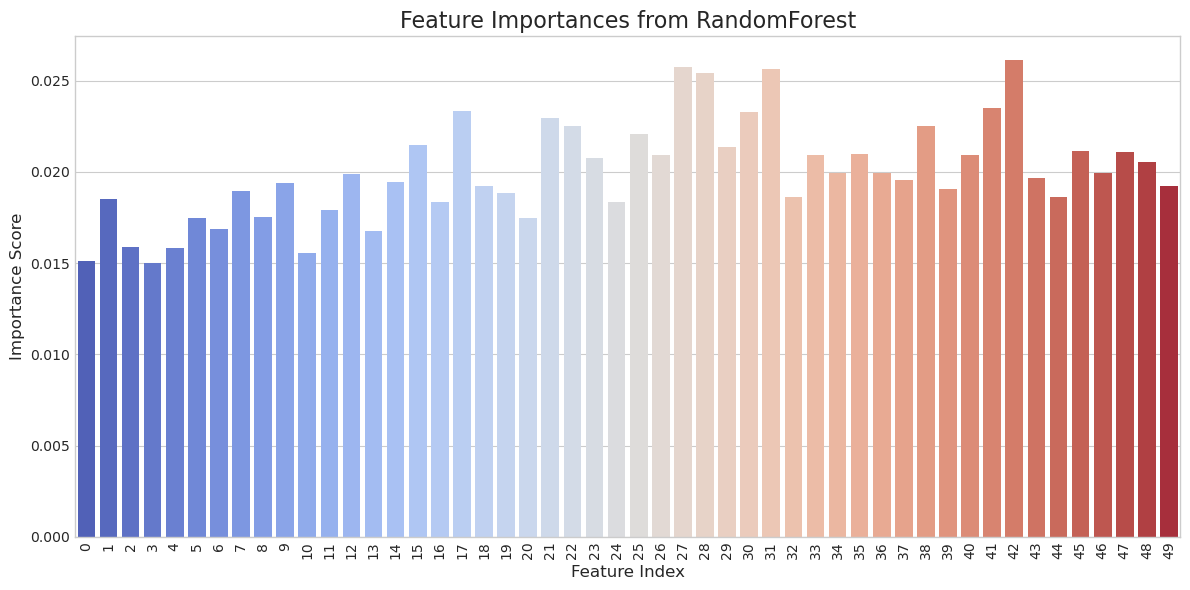

Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}
Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.86      0.80       120
           2       0.90      0.87      0.89       120
           3       0.82      0.82      0.82       120
           4       0.78      0.85      0.81       120
           5       0.84      0.86      0.85       120
           6       0.86      0.75      0.80       120
           7       0.93      0.85      0.89       120
           8       0.85      0.83      0.84       120
           9       0.74      0.82      0.78       120
          10       0.84      0.76      0.80       120
          11       0.86      0.85      0.86       120
          12       0.91      0.88      0.89       120
          13       0.82      0.88      0.85       120
          14       0.89      0.91      0.90       120
          15       0.82      0.74      0.78       120
          16  

<Figure size 1000x700 with 0 Axes>

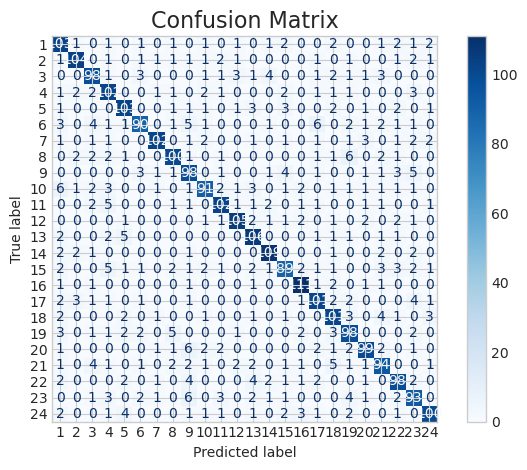

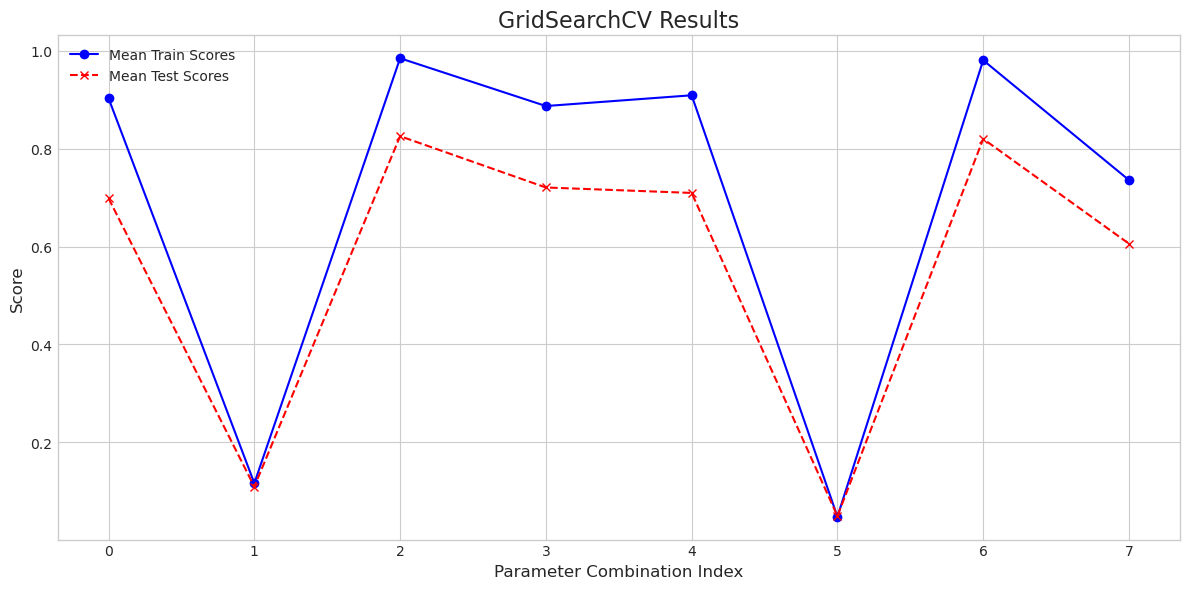

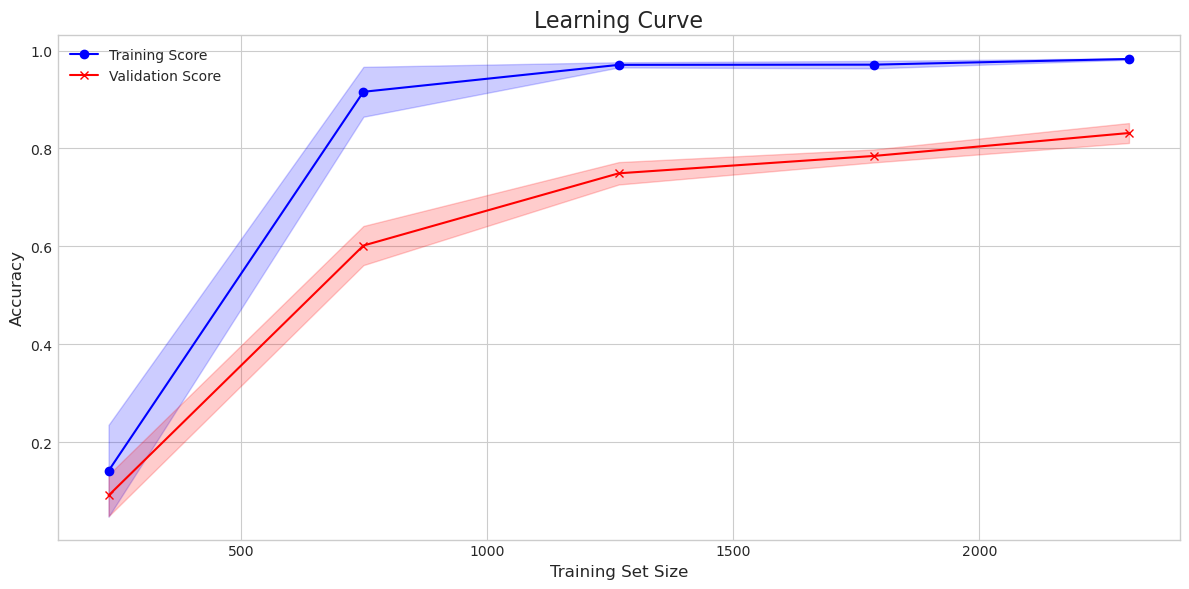

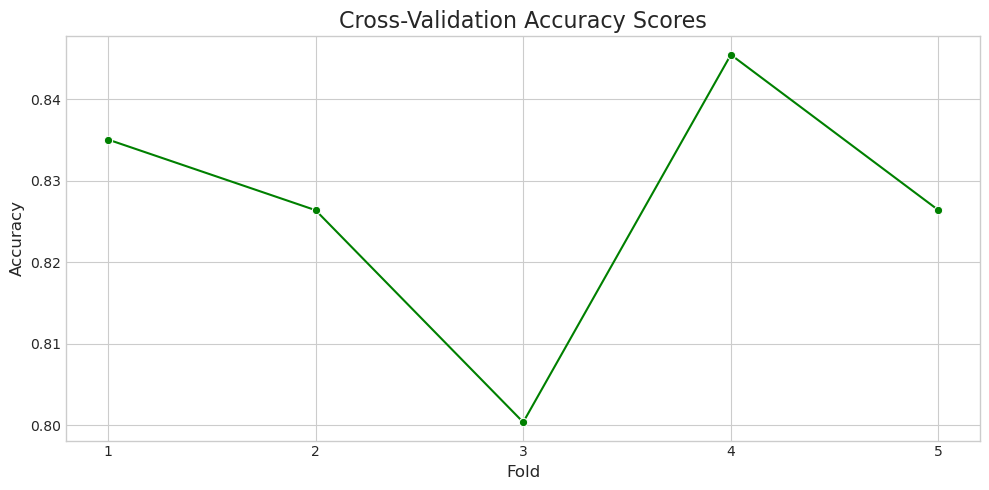

Mean cross-validation accuracy: 0.83


In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from brainiak.funcalign.srm import SRM
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for clarity
plt.style.use('seaborn-whitegrid')

# Z-score Normalization and SRM
beta_maps_reshaped = beta_maps.reshape(-1, beta_maps.shape[-1])
scaler = StandardScaler()  
beta_maps_scaled = scaler.fit_transform(beta_maps_reshaped)  
srm_input = [beta_maps_scaled.reshape(n_subjects, n_cycles, n_labels, -1)[i].reshape(-1, 59412).T for i in range(n_subjects)]

# Initialize SRM to find shared representations between subjects
srm = SRM(n_iter=10, features=50)
srm.fit(srm_input)

# Transform data into the shared space using SRM and concatenate for model input
X_srm = np.hstack([sr for sr in srm.transform(srm_input)]).T
y_srm = mapped_labels.reshape(-1)

# Feature selection using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# select the most important features
selector = SelectFromModel(rf_model, threshold='mean')

# Apply feature selection to reduce dimensionality
X_selected = selector.fit_transform(X_srm, y_srm)

# Fit the RandomForest model to get feature importances
rf_model.fit(X_srm, y_srm)
importances = rf_model.feature_importances_

# Visualize feature importances with clear labels and color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=np.arange(X_srm.shape[1]), y=importances, palette='coolwarm')
plt.title('Feature Importances from RandomForest', fontsize=16)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50, 20), (100, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.0001]
}

# Define the MLP neural network with early stopping
mlp = MLPClassifier(max_iter=10000, solver='adam', learning_rate='adaptive', early_stopping=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, return_train_score=True)

# Train the model using the selected hyperparameters
grid_search.fit(X_selected, y_srm)

# Display best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Cross-validation predictions and classification report
y_pred = cross_val_predict(grid_search.best_estimator_, X_selected, y_srm, cv=5)
print("Classification Report:\n", classification_report(y_srm, y_pred))

# Plot the confusion matrix with enhanced details and a heatmap
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_predictions(y_srm, y_pred, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# Plotting the Grid Search Results with clearer plot points and labels
results = grid_search.cv_results_
mean_train_scores = results['mean_train_score']
mean_test_scores = results['mean_test_score']

plt.figure(figsize=(12, 6))
plt.plot(mean_train_scores, label='Mean Train Scores', marker='o', linestyle='-', color='blue')
plt.plot(mean_test_scores, label='Mean Test Scores', marker='x', linestyle='--', color='red')
plt.title("GridSearchCV Results", fontsize=16)
plt.xlabel("Parameter Combination Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning Curve - Training and Validation Scores with clearer standard deviation bands
train_sizes, train_scores, val_scores = learning_curve(grid_search.best_estimator_, X_selected, y_srm, cv=5, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Enhanced plot of the learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o', color='blue')
plt.plot(train_sizes, val_mean, label="Validation Score", marker='x', color='red')

# Shaded regions to represent the standard deviations
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.2)

plt.title("Learning Curve", fontsize=16)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation Accuracy Scores Visualization
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
for train_index, test_index in cv.split(X_selected, y_srm):
    mlp.fit(X_selected[train_index], y_srm[train_index])
    y_pred_fold = mlp.predict(X_selected[test_index])
    accuracy_scores.append(accuracy_score(y_srm[test_index], y_pred_fold))

# Enhanced visualization of cross-validation accuracy scores
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(accuracy_scores) + 1), y=accuracy_scores, marker='o', linestyle='-', color='green')
plt.title("Cross-Validation Accuracy Scores", fontsize=16)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(1, len(accuracy_scores) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the mean accuracy across folds
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(accuracy_scores)))

## Conclusion

In this analysis, we successfully extracted and preprocessed beta maps from fMRI data for a set of subjects performing various sports-related tasks. Using **Shared Response Modeling (SRM)**, we reduced the dimensionality of the data to capture shared activity patterns across subjects. Additionally, feature selection was performed using a **Random Forest classifier**, enabling us to retain the most important features.

For classification, we applied a **Multi-layer Perceptron (MLP)** neural network with hyperparameter tuning using **GridSearchCV**. The model achieved a high cross-validation accuracy, with a mean accuracy of around **83%** across multiple folds, indicating robust generalization performance.

Visualization of the confusion matrix showed that the model was able to differentiate between various action categories with reasonable accuracy. However, there were still some misclassifications, suggesting room for improvement through potential adjustments to the model architecture, further hyperparameter tuning, or incorporating more advanced preprocessing techniques.

Overall, the results demonstrate the effectiveness of combining SRM with MLP classifiers for action recognition from fMRI data. Future work could explore more complex deep learning models, optimize the feature selection process, or experiment with different representations of fMRI data to further enhance classification performance.